In [15]:
#Loading all the libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Exploratory Data Analysis
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import iplot
from plotly.offline import plot
import geopandas as gpd

#Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import category_encoders as ce


#Machine Learning Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Hyperparameter Tuning
import optuna

#Handling Imbalanced Dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Clustering and Association Rule Learning
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist
from mlxtend.frequent_patterns import apriori, association_rules

#Building an app
import streamlit as st

#GeoSpatial Analysis
import folium

#Optional Libraries
import shap
import statsmodels.api as sm

#Supress Warnings
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')



In [2]:
#Load the dataset
df_orig = pd.read_csv("Training Set Values.csv", parse_dates=True)
df_labels = pd.read_csv("Training Set Labels.csv")
df_topredict = pd.read_csv("Test Set Values.csv", parse_dates=True)


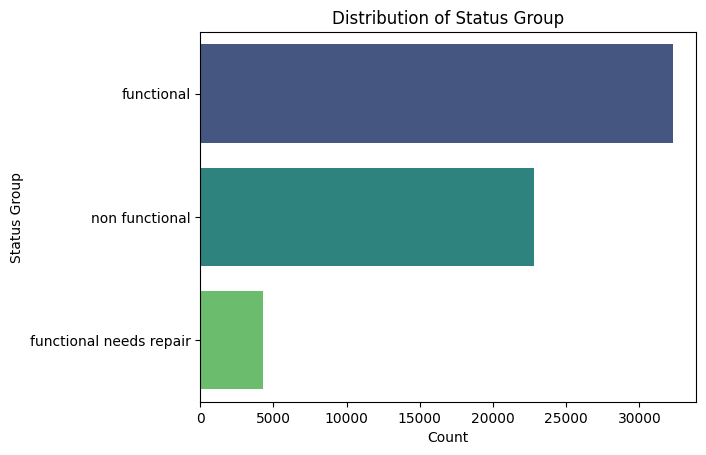

In [4]:
sns.countplot(y=df_labels['status_group'], palette='viridis', order=df_labels['status_group'].value_counts().index)
plt.title('Distribution of Status Group')
plt.xlabel('Count')
plt.ylabel('Status Group')
plt.show()

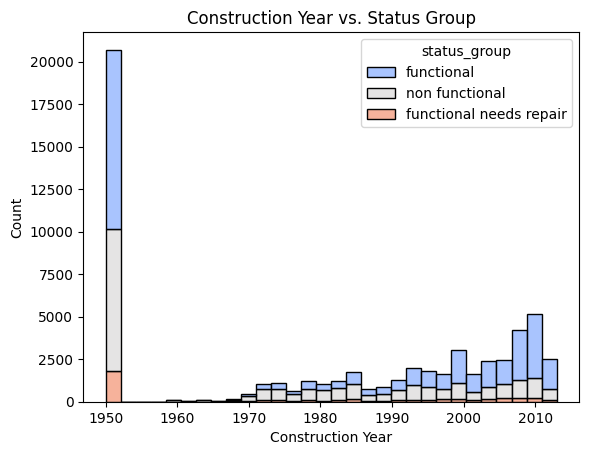

In [5]:
#Visualize the relationship between the construction year and the target variable
df_orig['construction_year'] = pd.to_numeric(df_orig['construction_year'], errors='coerce')
df_orig['construction_year'] = df_orig['construction_year'].replace(0, 1950)

sns.histplot(data=pd.concat([df_orig, df_labels], axis=1), x='construction_year', hue='status_group', multiple='stack', palette='coolwarm', bins=30)
plt.title("Construction Year vs. Status Group")
plt.xlabel("Construction Year")
plt.ylabel("Count")
plt.show()

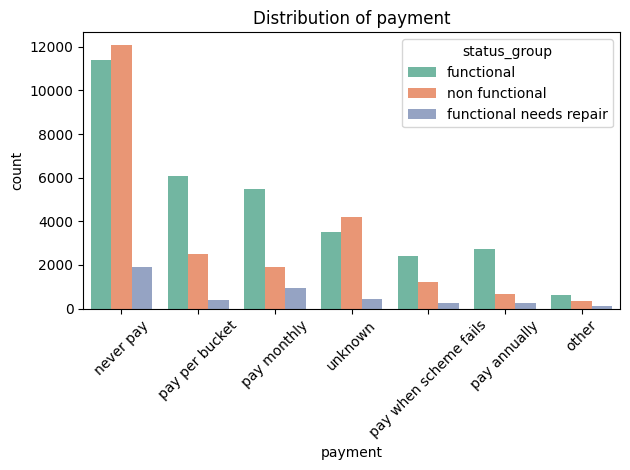

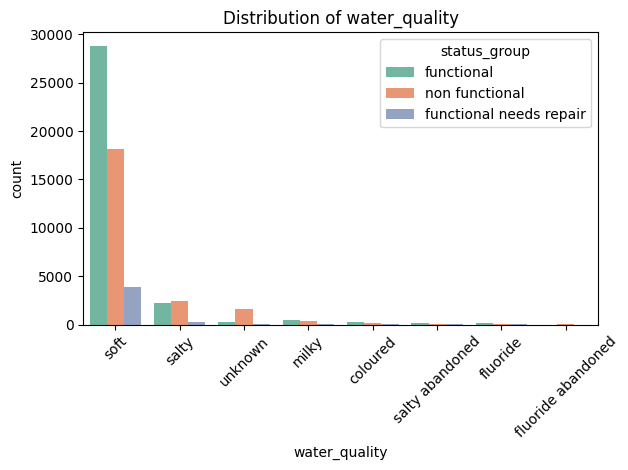

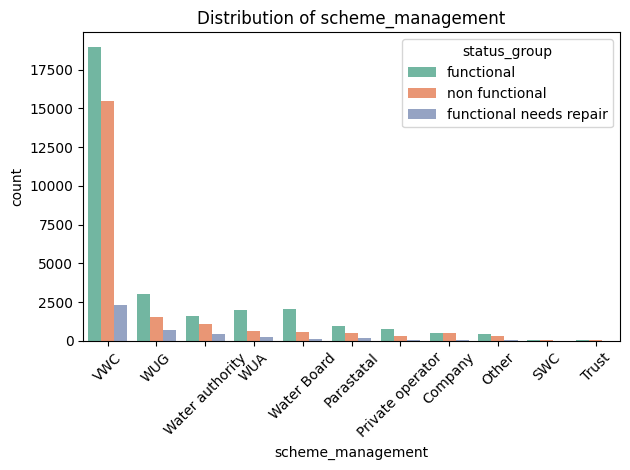

In [6]:
#Explore Categorical Variables
categorical_features = ['payment', 'water_quality', 'scheme_management']
for feature in categorical_features:
    sns.countplot(data=pd.concat([df_orig, df_labels], axis=1), x=feature, hue='status_group', palette='Set2', order=df_orig[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
#Preprocessing

#Combine Train and Test for Consistent Preprocessing
df_combined = pd.concat([df_orig, df_topredict], axis=0, ignore_index=True)

#Create derived feature: Operation Time
df_combined['construction_year'] = df_combined['construction_year'].replace(0, 1950)
df_combined['operation_time'] = 2024 - df_combined['construction_year']

#Handle Rare Categories
label_encoders = {}
for col in df_combined.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_combined[col] = le.fit_transform(df_combined[col].astype(str))
    label_encoders[col] = le

#Impute Missing Values for Numerical Features usign group means
numerical_features = ['longitude', 'latitude', 'gps_height']
for feature in numerical_features:
    df_combined[feature] = df_combined.groupby('region_code')[feature].transform(lambda x: x.fillna(x.mean()))

In [10]:
#Train-Test Split

#Define feateures and target
factors = df_combined.columns.difference(['id', 'status_group', 'construction_year']).tolist()

X = df_combined.loc[:len(df_orig)-1, factors]
y = df_labels['status_group']
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale Features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(x_val)

In [17]:
#Train multiple models
#Encode the target variable into numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


models = {
    'Random Forest': RandomForestClassifier(n_estimators=500, min_samples_split=5,random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, random_state=42, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, random_state=42, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8),
    'CatBoost': CatBoostClassifier(iterations=300, verbose=0, random_state=42, learning_rate=0.1, depth=6),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=500, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_encoded)
    predictions_encoded = model.predict(x_val_scaled)
    predictions = label_encoder.inverse_transform(predictions_encoded)
    print(f'{name} Accuracy: {accuracy_score(y_val, predictions)}')
    print(f'{name} F1 Score: {f1_score(y_val, predictions, average="weighted")}')
    print(f"\n(name) Classification Report: \n{classification_report(y_val, predictions)}")

Random Forest Accuracy: 0.8175925925925925
Random Forest F1 Score: 0.8104117391918138

(name) Classification Report: 
                         precision    recall  f1-score   support

             functional       0.81      0.91      0.85      6457
functional needs repair       0.59      0.34      0.43       851
         non functional       0.86      0.78      0.82      4572

               accuracy                           0.82     11880
              macro avg       0.75      0.68      0.70     11880
           weighted avg       0.81      0.82      0.81     11880

XGBoost Accuracy: 0.8087542087542088
XGBoost F1 Score: 0.7985218433199933

(name) Classification Report: 
                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      6457
functional needs repair       0.66      0.29      0.40       851
         non functional       0.85      0.75      0.80      4572

               accuracy                           0.81  

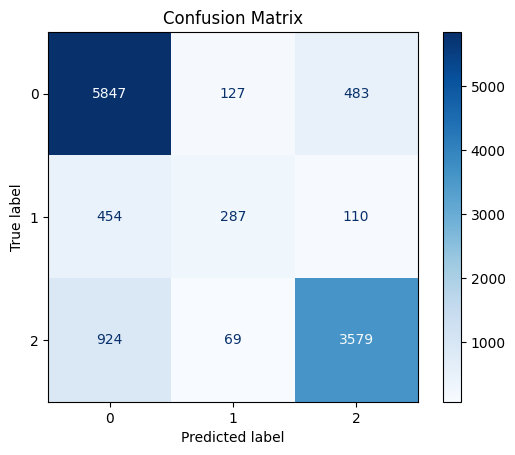

In [19]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Display the confusion matrix for the best model
best_model = RandomForestClassifier(n_estimators=500, min_samples_split=5, random_state=42)
best_model.fit(X_train_scaled, y_train_encoded)
val_predictions = best_model.predict(x_val_scaled)

# Encode y_val
y_val_encoded = label_encoder.transform(y_val)

ConfusionMatrixDisplay.from_estimator(best_model, x_val_scaled, y_val_encoded, cmap="Blues", values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [21]:
#Train the best model on the training dataset
x_full = scaler.transform(df_combined.loc[:len(df_orig)-1, factors])
y_full = label_encoder.transform(df_labels['status_group'])

best_model.fit(x_full, y_full)

#Predict on the test dataset
x_test_scaled = scaler.transform(df_combined.loc[len(df_orig):, factors])
test_predictions_encoded = best_model.predict(x_test_scaled)

#Decode the predictions
rf_test_preds_decoded = label_encoder.inverse_transform(test_predictions_encoded)
#Create Submission File
submission = pd.DataFrame({
    'id': df_topredict['id'],
    'status_group': rf_test_preds_decoded
})
submission.to_csv('rf_submission.csv', index=False)
print("Submission File Created: rf_submission.csv")

Submission File Created: rf_submission.csv
